In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns=500
pd.options.display.max_info_rows=550
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from xgboost import XGBRegressor

2022-09-12 14:46:20.378002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 14:46:20.378055: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from carbon_forecast.utils.preproc import load_n_preproc_all_avail
df = load_n_preproc_all_avail()


Reading data...
Preproc on power % revenue
Preproc on Sector Revenue
Selecting the year 2013 required...
Dropping rows that are showing NaN on...
-> intensity_scope1CY2013
-> intensity_scope2CY2013
-> intensity_scope3CY2013
-> Revenue2013
Filling employee numbers with mean value... (subject to change later)
Filling EV with mean value... (subject to change later)
Calculating Employees & EV per Revenue...
Filling null Climate Strategy Score with 0...
Cleaning P/E Ratio...
Adding Scope 1 and Scope 2 data together...
Doing some column renaming...
Dataset preproc-ed for the year 2013!👍
Reading data...
Preproc on power % revenue
Preproc on Sector Revenue
Selecting the year 2014 required...
Dropping rows that are showing NaN on...
-> intensity_scope1CY2014
-> intensity_scope2CY2014
-> intensity_scope3CY2014
-> Revenue2014
Filling employee numbers with mean value... (subject to change later)
Filling EV with mean value... (subject to change later)
Calculating Employees & EV per Revenue...
Filli

In [3]:
df.Sector.unique()

array(['Communication Services', 'Information Technology', 'Financials',
       'Industrials', 'Consumer Discretionary', 'Consumer Staples',
       'Utilities', 'Real Estate', 'Health Care', 'Materials', 'Energy'],
      dtype=object)

In [4]:
df = df[df["Sector"] == "Industrials"]
X = df.drop(columns=["company_name", "TCUID", "year", "intensity_1and2","intensity_scope3"])
y = df["intensity_1and2"]

In [5]:
X

,Sector,Employees / Revenue,EV / Revenue,climate_strategy_score,disclosure,pe_rat,revenue,nuclear_percentage_revenue,thermal_coal_percentage_revenue,ultra_deep_sea_drilling_percentage_revenue,shale_oil_gas_percentage_revenue,coal_percentage_revenue,arctic_drilling_percentage_revenue,oil_sands_percentage_revenue,Abrasive product manufacturing,"Accounting, tax preparation, bookkeeping, and payroll services",Adhesive manufacturing,Advertising and related services,Air and gas compressor manufacturing,"Air conditioning, refrigeration, and warm air heating equipment manufacturing",Air purification and ventilation equipment manufacturing,Air transportation,Aircraft engine and engine parts manufacturing,Aircraft manufacturing,Alkalies and chlorine manufacturing,All other basic inorganic chemical manufacturing,All other chemical product and preparation manufacturing,All other converted paper product manufacturing,All other crop farming,All other food manufacturing,"All other forging, stamping, and sintering",All other miscellaneous electrical equipment and component manufacturing,All other miscellaneous manufacturing,"All other miscellaneous professional, scientific, and technical services",All other miscellaneous wood product manufacturing,All other paper bag and coated and treated paper manufacturing,All other petroleum and coal products manufacturing,All other textile product mills,All other transportation equipment manufacturing,Alumina refining and primary aluminum production,Aluminum product manufacturing from purchased aluminum,Ammunition manufacturing,"Amusement parks, arcades, and gambling industries",Analytical laboratory instrument manufacturing,"Animal (except poultry) slaughtering, rendering, and processing","Animal production, except cattle and poultry and eggs",Apparel accessories and other apparel manufacturing,Apparel knitting mills,"Apparel, Piece Goods, and Notions Wholesalers","Architectural, engineering, and related services","Arms, ordnance, and accessories manufacturing",Artificial and synthetic fibers and filaments manufacturing,Asphalt paving mixture and block manufacturing,Asphalt shingle and coating materials manufacturing,Audio and video equipment manufacturing,Automatic environmental control manufacturing,Automobile manufacturing,Automotive equipment rental and leasing,"Automotive repair and maintenance, except car washes",Ball and roller bearing manufacturing,Bare printed circuit board manufacturing,Bauxite Mining,Beet sugar manufacturing,Biological product (except diagnostic) manufacturing,Biomass Power Generation,Bituminous Coal Underground Mining,Bituminous Coal and Lignite Surface Mining,Blind and shade manufacturing,Boat building,Book publishers,Bowling centers,Bread and bakery product manufacturing,Breakfast cereal manufacturing,Breweries,"Brick, tile, and other structural clay product manufacturing",Broadcast and wireless communications equipment,Broadwoven fabric mills,"Broom, brush, and mop manufacturing",Building Material and Garden Equipment and Supplies Dealers,Business support services,Cable and other subscription programming,Car washes,Carbon and graphite product manufacturing,Carbon black manufacturing,Carpet and rug mills,Cattle ranching and farming,Cement manufacturing,Cheese manufacturing,Child day care services,Chocolate and confectionery manufacturing from cacao beans,Clay and nonclay refractory manufacturing,Clothing and Clothing Accessories Stores,Coal Power Generation,"Coated and laminated paper, packaging paper and plastics film manufacturing","Coating, engraving, heat treating and allied activities",Coffee and tea manufacturing,Commercial and industrial machinery and equipment rental and leasing,Commercial and industrial machinery and equipment repair and maintenance,Communication and energy wire and cable manufacturing,"Community food, housing, and other relief services, including rehabilitation services",Computer storage device manufacturing,Computer systems design services,Compu

In [6]:
y.describe()

count     15302.000000
mean        222.458312
std        2273.098542
min           0.023000
25%          29.930912
50%          44.174657
75%          96.428278
max      207408.900077
Name: intensity_1and2, dtype: float64

(array([1.5296e+04, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.30000000e-02, 2.07409107e+04, 4.14817984e+04, 6.22226861e+04,
        8.29635738e+04, 1.03704462e+05, 1.24445349e+05, 1.45186237e+05,
        1.65927125e+05, 1.86668012e+05, 2.07408900e+05]),
 <BarContainer object of 10 artists>)

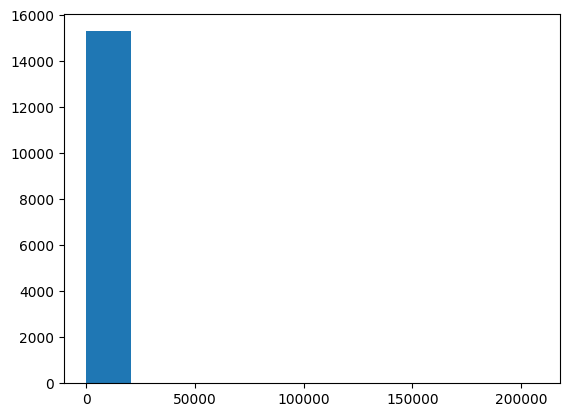

In [7]:
plt.hist(y)

In [8]:
mean_absolute_percentage_error(y,y.mean())

2022-09-12 14:46:31.951324: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-12 14:46:31.951748: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-12 14:46:31.952416: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (VIVOLC): /proc/driver/nvidia/version does not exist
2022-09-12 14:46:31.966810: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(), dtype=float64, numpy=847.0781716118611>

In [9]:
from carbon_forecast.utils.tx import tt_split, our_tx
tx = our_tx(X)
X_train_transformed, X_test_transformed, y_train, y_test = tt_split(X,y,tx)

In [10]:
# model = XGBRegressor(n_estimators=1500, max_depth=15, objective="reg:squarederror", eval_metric="mape")
# cross_val_score(model, X_train_transformed, y_train, cv=5, scoring="neg_mean_absolute_percentage_error")

In [11]:
# model.fit(X_train_transformed, y_train)
# y_pred = model.predict(X_test_transformed)

In [12]:
# mean_absolute_percentage_error(y_test, y_pred)

In [13]:
# y_test, y_pred

In [14]:
# y_test - y_pred

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_transformed)

PCA()

In [16]:
# Access our  PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,
                 )
W

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457
0,-0.001041,-0.001206,-0.001527,0.000828,-0.000558,-0.000718,-0.000298,-0.001758,-0.001338,-0.000366,-0.002206,-0.001072,0.000040,0.000805,0.000331,0.001187,-0.000603,-0.003968,-0.000247,-0.001522,-0.001649,-0.000297,0.000107,-0.003608,-0.000243,-0.000036,0.005521,-0.000256,-0.001700,-0.000467,-0.000700,-0.002307,-0.000464,-0.000256,-0.000063,-0.000576,-0.000536,-0.000845,-0.003451,-0.000364,-0.000207,0.000796,-0.001375,-0.000326,0.000214,0.000726,0.001191,0.000125,0.001816,0.001453,-0.000700,0.000624,0.002452,0.000945,0.001340,-0.000446,0.008171,-0.007082,0.002058,0.004254,0.003143,0.007658,-0.006309,0.012190,-0.011445,-0.007711,0.013200,0.001901,-0.000325,0.003640,-0.018130,0.011154,-0.015314,-0.009022,-0.005179,-0.008047,-0.002646,-0.010227,-0.003589,-0.000992,0.001056,0.000859,0.003433,-0.000308,0.004951,0.026638,0.045162,-0.008914,-0.013194,-0.016211,-0.008076,-0.016901,-0.003518,-0.006905,0.005285,-0.003062,-0.010755,-0.002433,0.002987,-0.001303,-0.000109,-0.054377,-0.000517,-0.001096,0.000989,0.006345,0.002258,0.001082,0.001176,-0.001361,-0.002520,0.004556,0.006656,0.000253,0.002064,-0.000338,-0.009775,0.004436,-0.004578,-0.013620,0.008223,0.006412,0.004719,0.001073,-0.005281,-0.011940,0.014324,0.021732,0.002440,0.006799,0.000395,-0.009662,-0.009101,-0.011891,0.000310,0.008341,-0.002092,0.007351,-0.005318,-0.005663,-0.005879,0.005373,0.013486,-0.007760,0.011533,0.001283,0.010227,-0.006450,0.001746,0.005571,0.004475,0.000909,0.002280,0.001796,0.004543,-0.039072,-0.015935,-0.009710,-0.005424,-0.026508,0.007127,-0.065884,0.030902,0.034816,-0.006825,-0.002692,0.034494,-0.019246,0.007655,-0.004045,0.007366,-0.034657,0.027699,-0.011585,0.001609,0.035163,0.025388,0.040903,0.093726,0.142752,0.104086,-0.038102,0.041568,-0.053116,0.011841,0.063516,-0.147036,0.017071,0.060579,0.012980,0.696982,0.113895,-0.229052,-0.061280,-0.184215,0.323866,-0.090655,0.058396,-0.045639,-0.013199,0.131535,0.013019,0.006882,0.003084,0.000006,-0.010884,0.034781,-0.048793,0.056762,-0.046083,-0.001567,-0.029010,0.015856,-0.011533,-0.022187,-0.004053,-0.010864,-0.011270,-0.011303,-0.018777,-0.009216,0.003965,0.001339,0.012461,-0.011176,0.018490,-0.021798,-0.003487,0.001070,-0.007448,-0.023427,-0.014798,-0.036730,-0.001544,-0.016670,-0.042787,-0.123062,-0.094307,0.

In [17]:
X_proj = pca.transform(X_train_transformed)
X_proj

array([[-3.36332377e-01,  8.02331869e-03, -4.38452468e-02, ...,
         0.00000000e+00, -4.03865309e-17,  1.71371706e-17],
       [-3.46609346e-01,  9.16081861e-01,  7.85790488e-02, ...,
         0.00000000e+00, -2.10335221e-17, -2.08505630e-17],
       [ 7.30150855e-01, -5.70240701e-02, -9.29676462e-02, ...,
         0.00000000e+00, -1.14871220e-16,  8.47710574e-18],
       ...,
       [-3.41897776e-01, -6.88114662e-02, -5.94775823e-02, ...,
         0.00000000e+00, -2.04914211e-17, -5.00765878e-18],
       [-3.39123323e-01, -7.28453612e-02, -6.06026078e-02, ...,
         0.00000000e+00, -2.86771475e-17,  1.38574590e-17],
       [ 6.69694955e-01, -9.98540089e-02, -3.16362052e-02, ...,
         0.00000000e+00, -2.71050543e-18,  3.83604281e-17]])

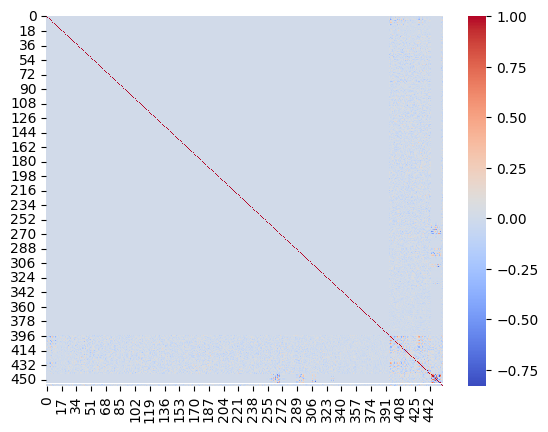

In [18]:
import seaborn as sns
sns.heatmap(pd.DataFrame(X_proj).corr(), cmap='coolwarm');


(0.0, 30.0)

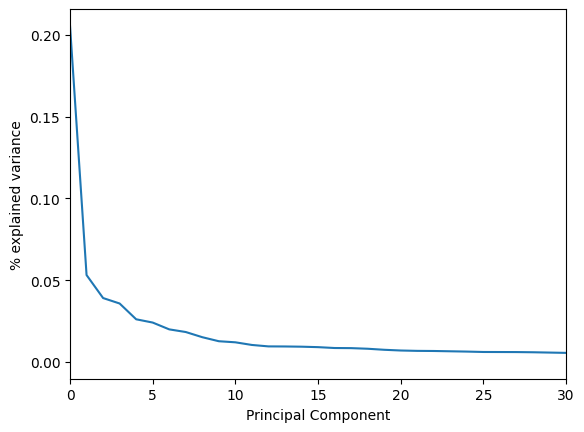

In [35]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');
plt.xlim(0,30)

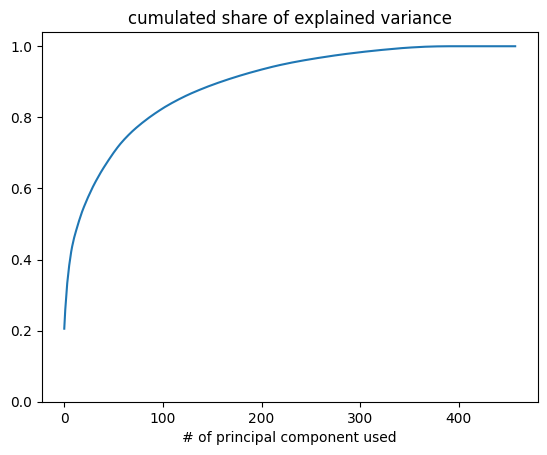

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [36]:
pca3 = PCA(n_components=3).fit(X_train_transformed)
X_proj3 = pca3.fit_transform(X_train_transformed)
X_proj3

array([[-0.33633238,  0.00802335, -0.04384537],
       [-0.34660935,  0.91608184,  0.07857775],
       [ 0.73015085, -0.05702403, -0.09296825],
       ...,
       [-0.34189778, -0.06881152, -0.05947734],
       [-0.33912332, -0.07284551, -0.06060577],
       [ 0.66969495, -0.09985403, -0.03163636]])

In [37]:
model_pca = XGBRegressor(n_estimators=1000, max_depth=15, objective="reg:squarederror", eval_metric="mape")
cross_val_score(model_pca, X_proj3, y_train, cv=5, scoring="neg_mean_absolute_percentage_error")

array([-3.30280768, -2.29721354, -3.10229467, -2.58155171, -4.50734589])

In [39]:
X_test_proj3 = pca3.transform(X_test_transformed)

In [40]:
model_pca.fit(X_proj3, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mape', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [41]:
y_pred = model_pca.predict(X_test_proj3)

In [42]:
y_test

14123     133.184604
14450    1012.608797
15068      14.525516
1849       45.531000
4250       58.451560
            ...     
4857       17.562222
9438       17.835000
11146     488.352000
12149      11.875439
7596      386.047210
Name: intensity_1and2, Length: 4591, dtype: float64

In [43]:
mean_absolute_percentage_error(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=203.52423>